In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'FTS.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,1173,-474,699,118,72,732,143,1296,2075,...,17908,0,160,787,2084,6424,11907,230,-354,214
1,2014-03-31,1455,-679,776,154,528,865,75,1714,2097,...,18590,0,663,744,2542,6421,12451,265,-237,276
2,2014-06-30,1056,-403,653,63,612,628,127,1576,2074,...,18586,0,699,721,2484,6443,12463,321,-298,276
3,2014-09-30,1197,-406,791,32,458,782,347,3243,3652,...,26740,0,1564,1109,4175,10886,19954,62,-340,276
4,2014-12-31,1693,-709,984,136,230,900,321,1787,3732,...,26233,0,330,733,2676,9911,17542,334,-850,276


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,488,3168,-1268,1900,420,209,1759,661,...,1548,64252,0,253,2481,6617,25931,43222,869,-1114
37,2023-03-31,2023-04-21,490,3319,-1312,2007,484,576,1876,569,...,1511,64630,0,361,2362,6150,26466,43363,915,-954
38,2023-06-30,2023-07-21,490,2594,-787,1807,346,690,1580,534,...,1492,64081,0,80,2284,5414,26808,42702,944,-982
39,2023-09-30,2023-10-21,490,2719,-773,1946,445,765,1648,588,...,1515,66285,0,78,2774,6368,27170,44593,940,-983
40,2023-12-31,2024-02-11,490,2885,899,1986,435,625,1627,566,...,1510,65920,0,119,2296,5964,27235,42588,746,-1250


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,488,3168,-1268,1900,420,209,1759,661,...,64252,0,253,2481,6617,25931,43222,869,-1114,1.357405
37,2023-03-31,2023-04-21,490,3319,-1312,2007,484,576,1876,569,...,64630,0,361,2362,6150,26466,43363,915,-954,1.352063
38,2023-06-30,2023-07-21,490,2594,-787,1807,346,690,1580,534,...,64081,0,80,2284,5414,26808,42702,944,-982,1.343352
39,2023-09-30,2023-10-21,490,2719,-773,1946,445,765,1648,588,...,66285,0,78,2774,6368,27170,44593,940,-983,1.341033
40,2023-12-31,2024-02-11,490,2885,899,1986,435,625,1627,566,...,65920,0,119,2296,5964,27235,42588,746,-1250,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,488,3168,-1268,1900,420,209,1759,661,...,64252,0,253,2481,6617,25931,43222,869,-1114,1.357405
37,2023-03-31,2023-04-21,490,3319,-1312,2007,484,576,1876,569,...,64630,0,361,2362,6150,26466,43363,915,-954,1.352063
38,2023-06-30,2023-07-21,490,2594,-787,1807,346,690,1580,534,...,64081,0,80,2284,5414,26808,42702,944,-982,1.343352
39,2023-09-30,2023-10-21,490,2719,-773,1946,445,765,1648,588,...,66285,0,78,2774,6368,27170,44593,940,-983,1.341033
40,2023-12-31,2024-02-11,490,2885,899,1986,435,625,1627,566,...,65920,0,119,2296,5964,27235,42588,746,-1250,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,21.064383,2013-12-31,1173.0,2.205607,28.042056,214.0,2336.0,10.915888,72.0,...,0.335102,0.664898,6.409836,inf,65.166667,13.258741,0.595908,0.100597,0.026357,0.078654
1,2014-02-24,21.002668,2013-12-31,1173.0,2.205607,28.042056,214.0,2336.0,10.915888,72.0,...,0.335102,0.664898,6.409836,inf,65.166667,13.258741,0.595908,0.100597,0.026357,0.078654
2,2014-03-03,21.002668,2013-12-31,1173.0,2.205607,28.042056,214.0,2336.0,10.915888,72.0,...,0.335102,0.664898,6.409836,inf,65.166667,13.258741,0.595908,0.100597,0.026357,0.078654
3,2014-03-10,21.448372,2013-12-31,1173.0,2.205607,28.042056,214.0,2336.0,10.915888,72.0,...,0.335102,0.664898,6.409836,inf,65.166667,13.258741,0.595908,0.100597,0.026357,0.078654
4,2014-03-17,21.386658,2013-12-31,1173.0,2.205607,28.042056,214.0,2336.0,10.915888,72.0,...,0.335102,0.664898,6.409836,inf,65.166667,13.258741,0.595908,0.100597,0.026357,0.078654


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,21.064383,2013-12-31,1173.0,2.205607,28.042056,214.0,2336.0,10.915888,72.0,...,13.258741,0.595908,0.100597,0.026357,0.078654,9.550377,0.751171,0.960737,3.483115,1.929699
1,2014-02-24,21.002668,2013-12-31,1173.0,2.205607,28.042056,214.0,2336.0,10.915888,72.0,...,13.258741,0.595908,0.100597,0.026357,0.078654,9.522396,0.748970,0.957922,3.480301,1.924046
2,2014-03-03,21.002668,2013-12-31,1173.0,2.205607,28.042056,214.0,2336.0,10.915888,72.0,...,13.258741,0.595908,0.100597,0.026357,0.078654,9.522396,0.748970,0.957922,3.480301,1.924046
3,2014-03-10,21.448372,2013-12-31,1173.0,2.205607,28.042056,214.0,2336.0,10.915888,72.0,...,13.258741,0.595908,0.100597,0.026357,0.078654,9.724474,0.764864,0.978251,3.500629,1.964877
4,2014-03-17,21.386658,2013-12-31,1173.0,2.205607,28.042056,214.0,2336.0,10.915888,72.0,...,13.258741,0.595908,0.100597,0.026357,0.078654,9.696493,0.762664,0.975436,3.497814,1.959223


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

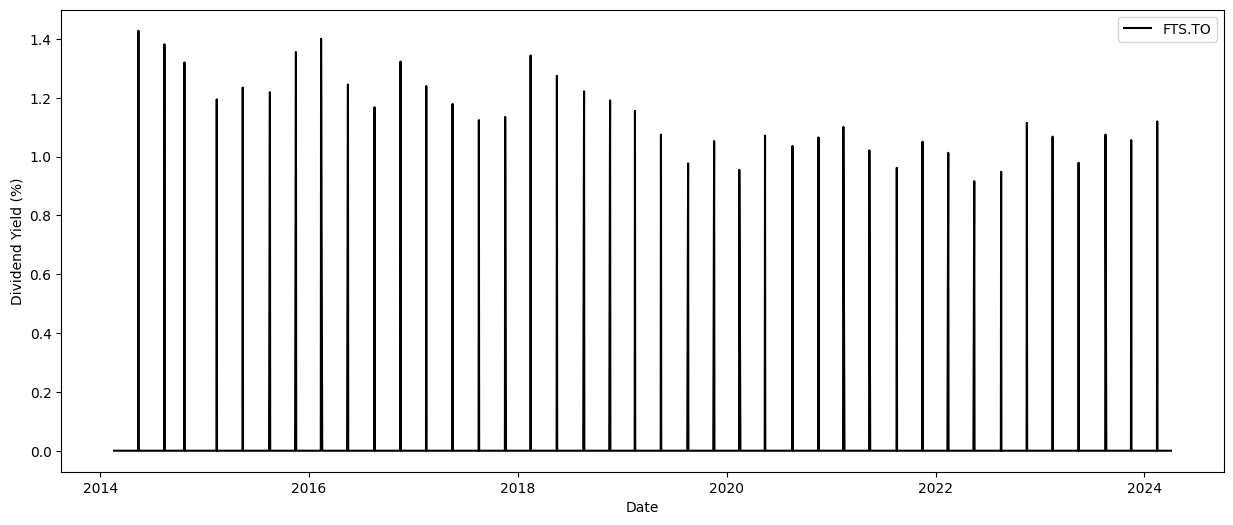

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.441799
share_price      1.000000
Name: share_price, dtype: float64


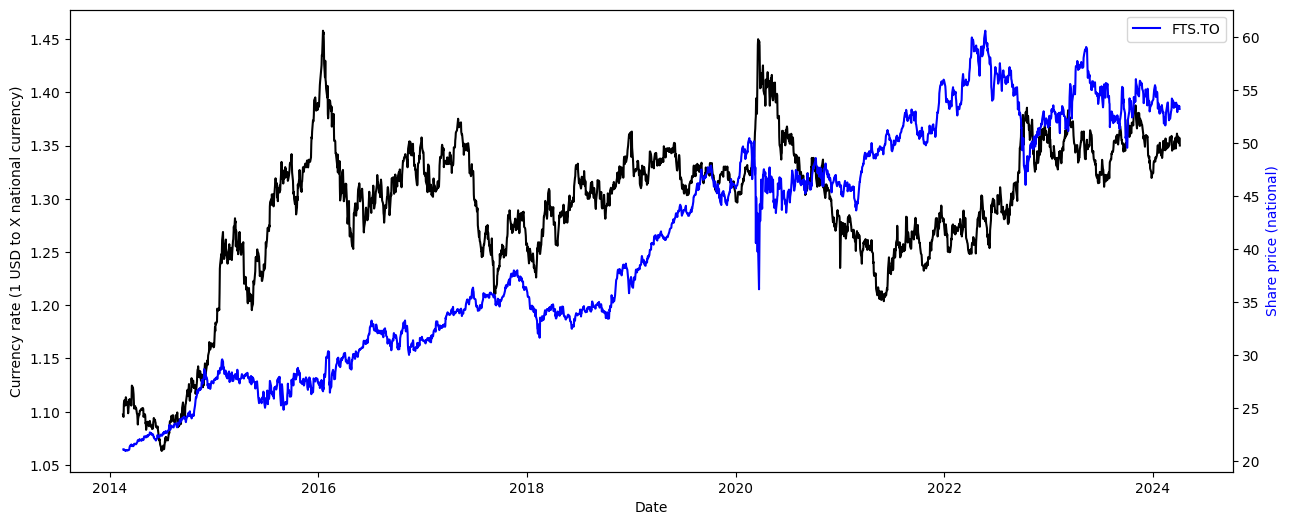

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

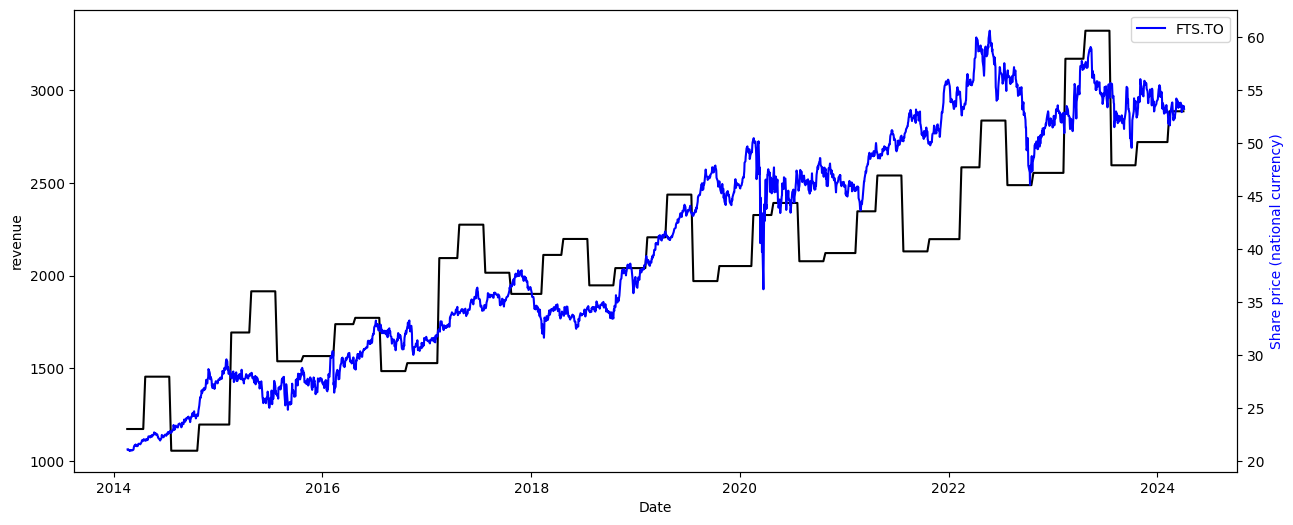

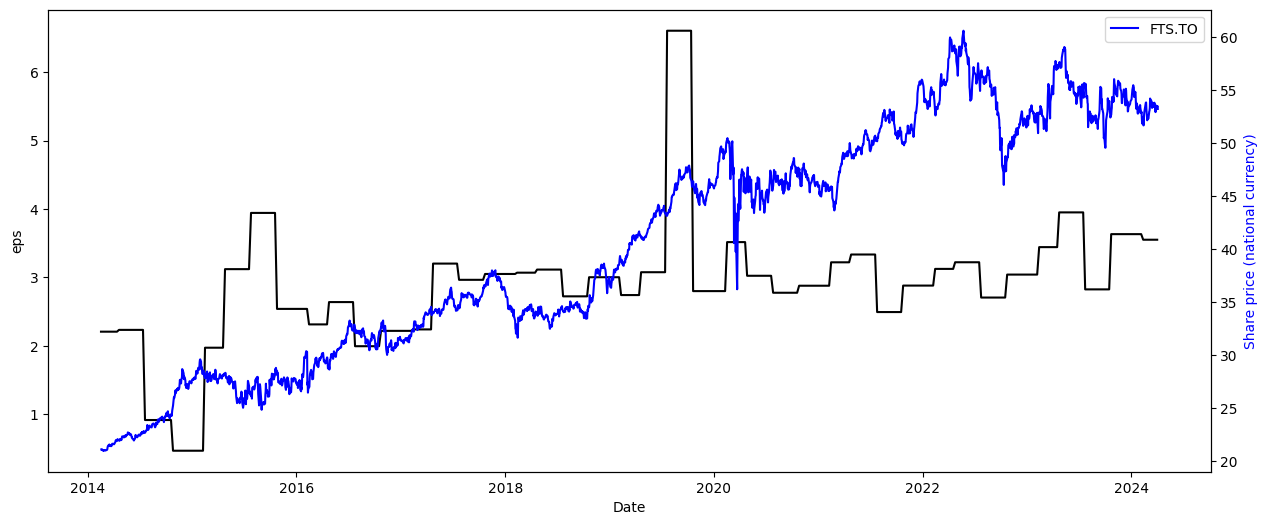

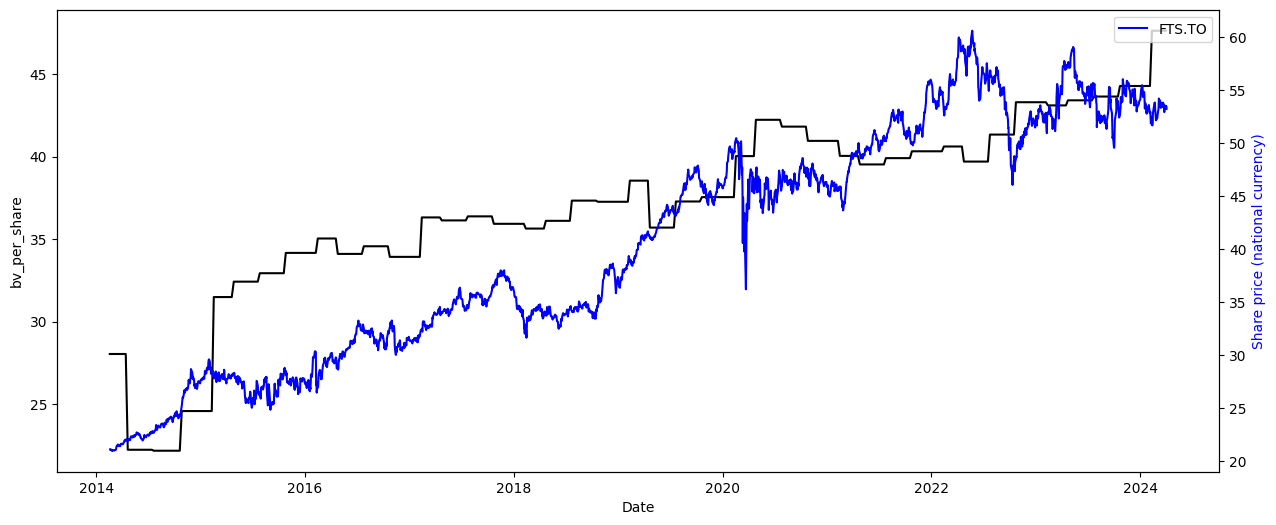

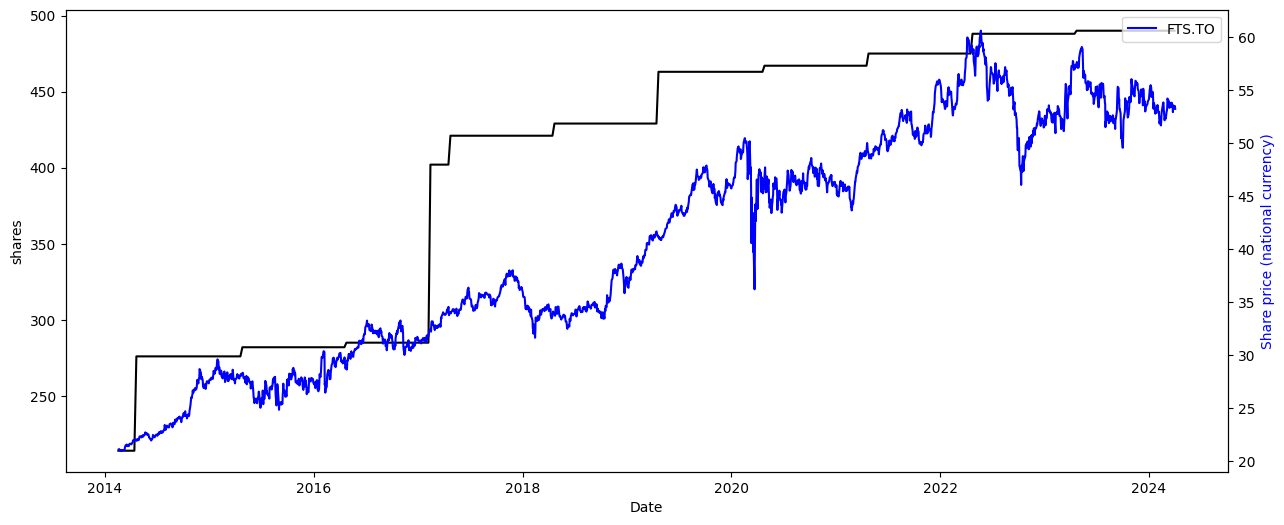

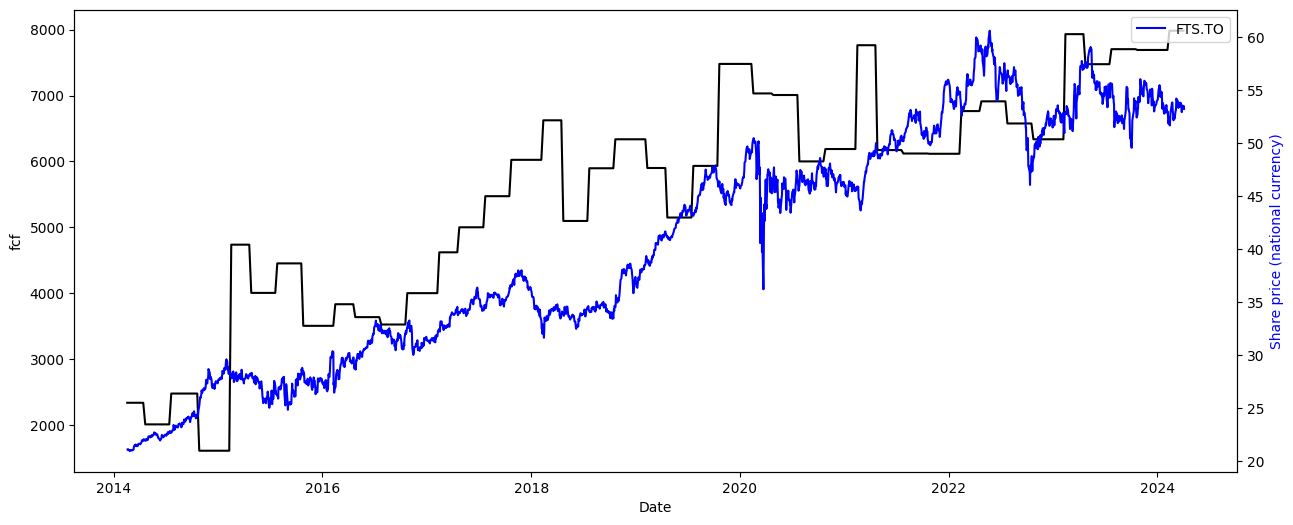

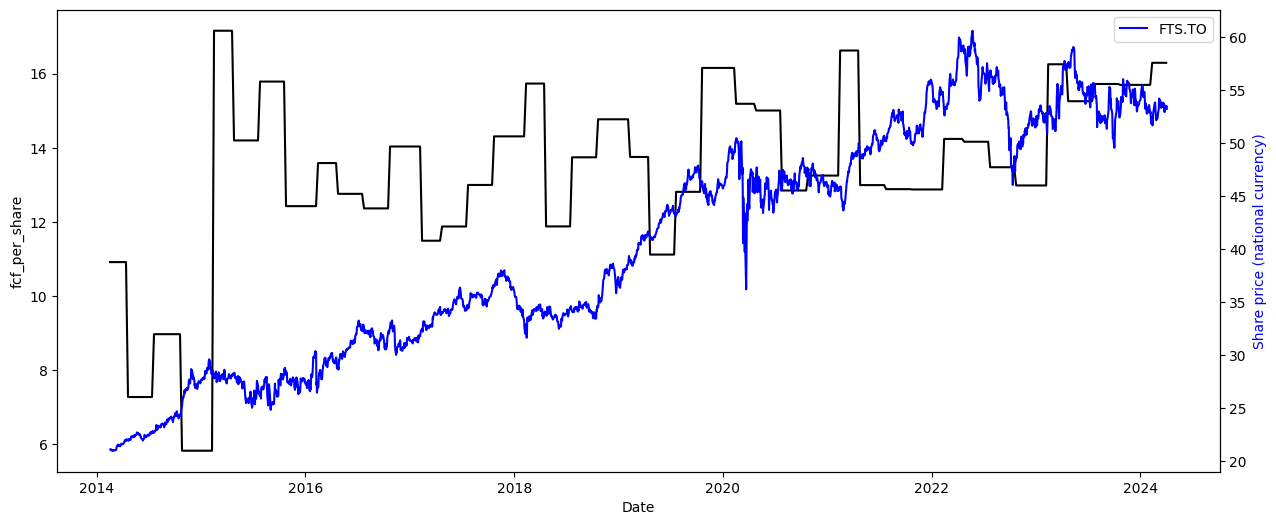

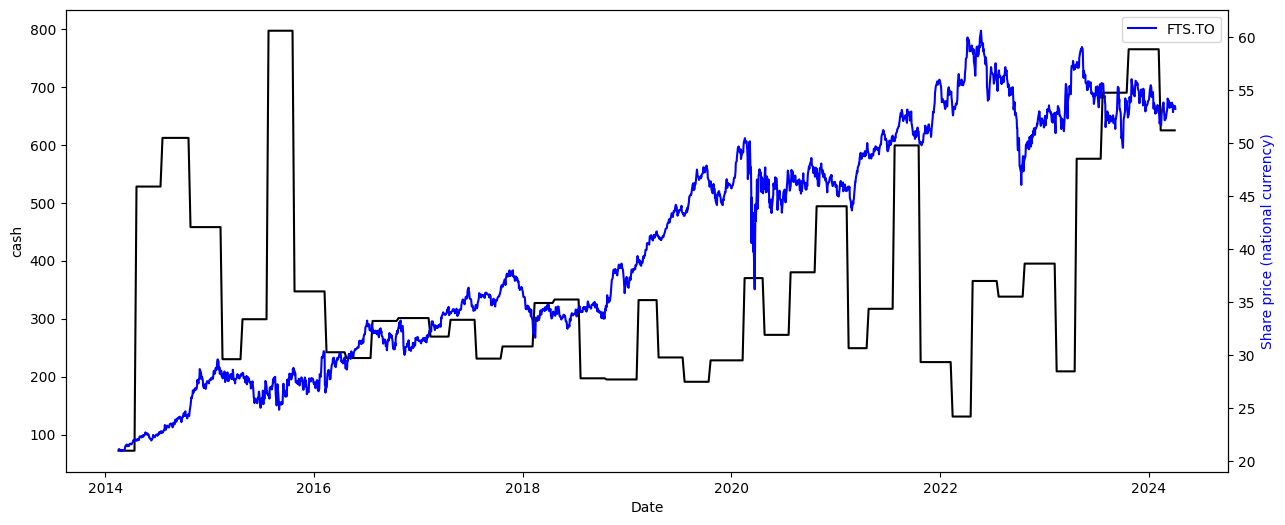

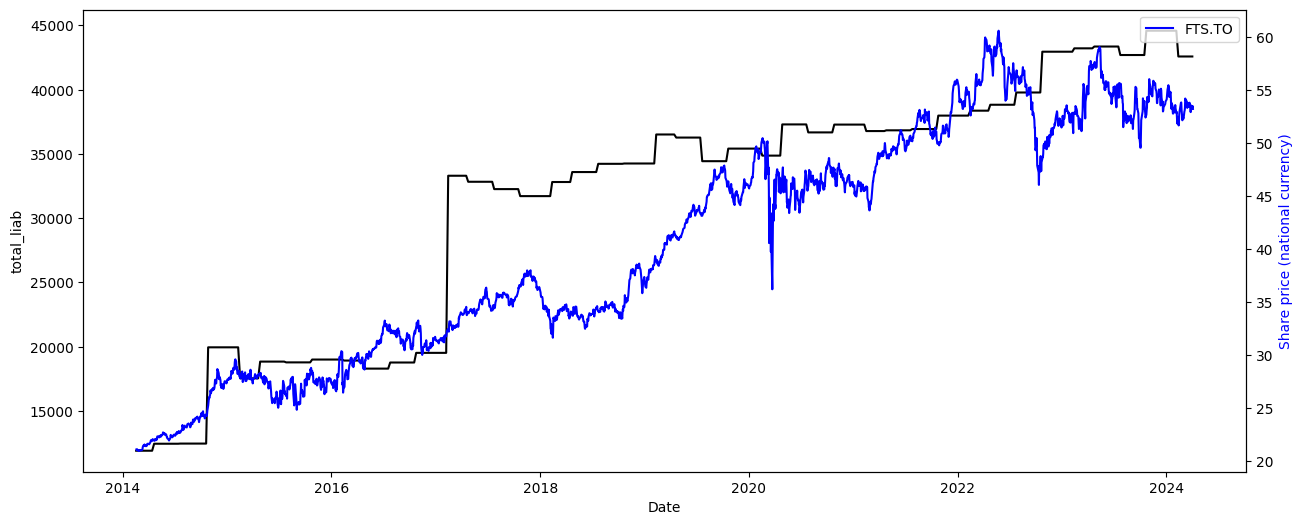

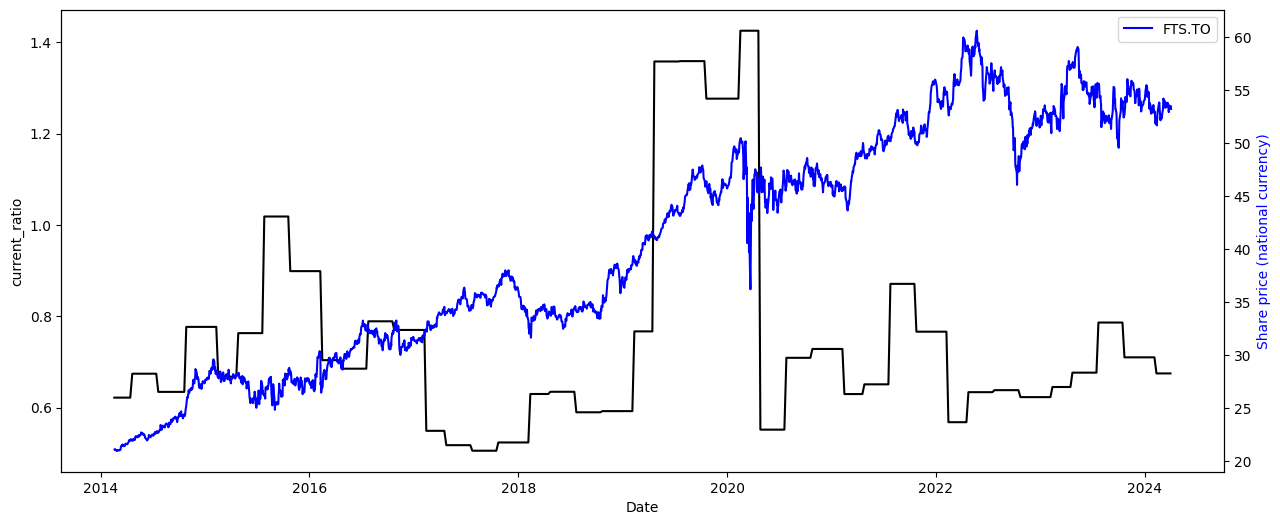

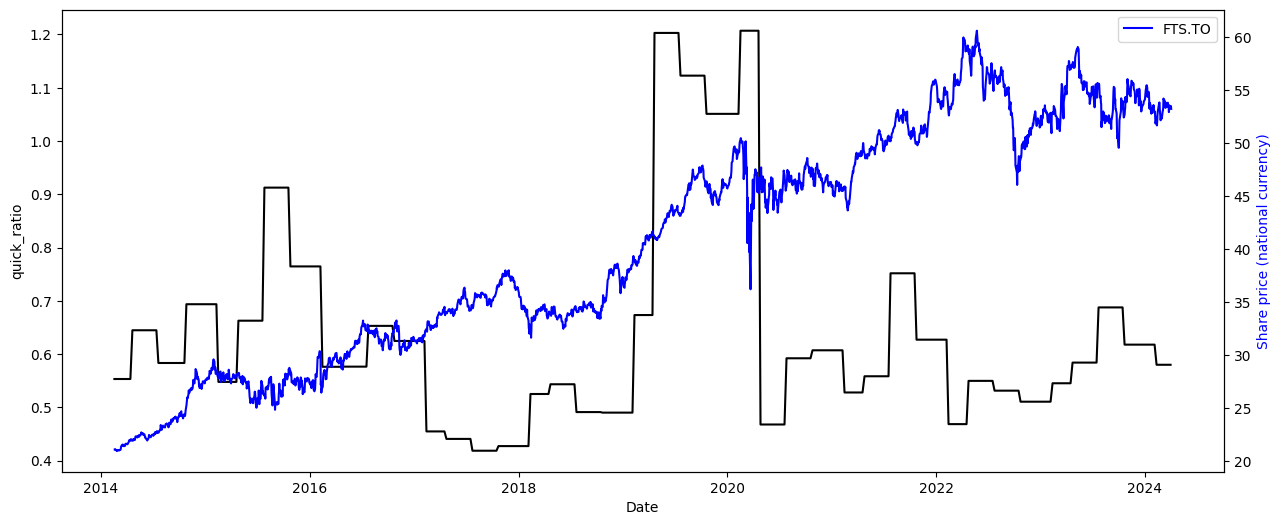

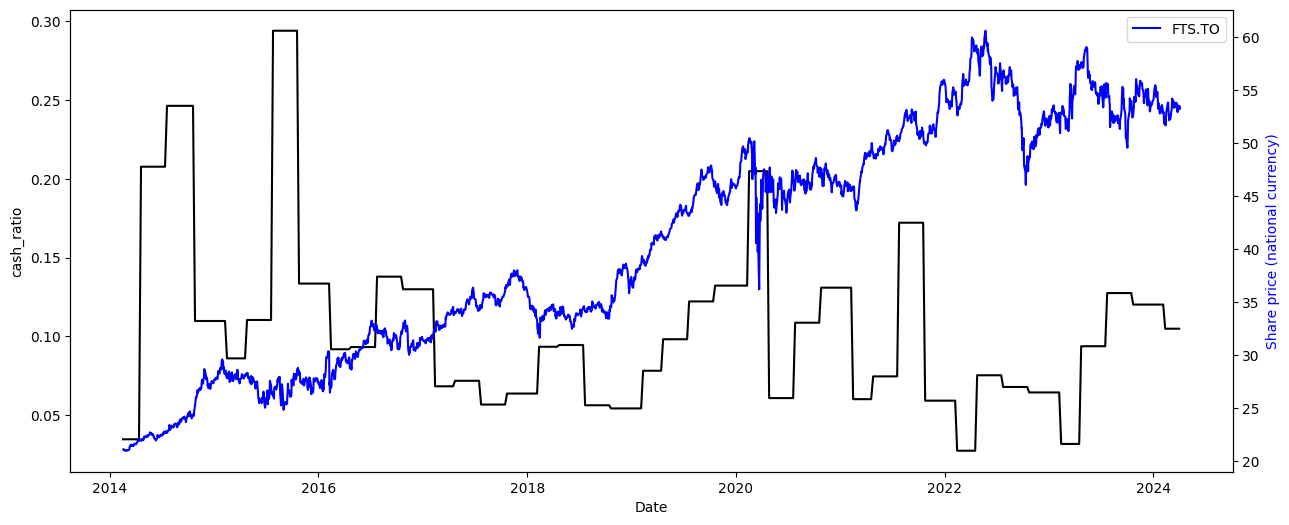

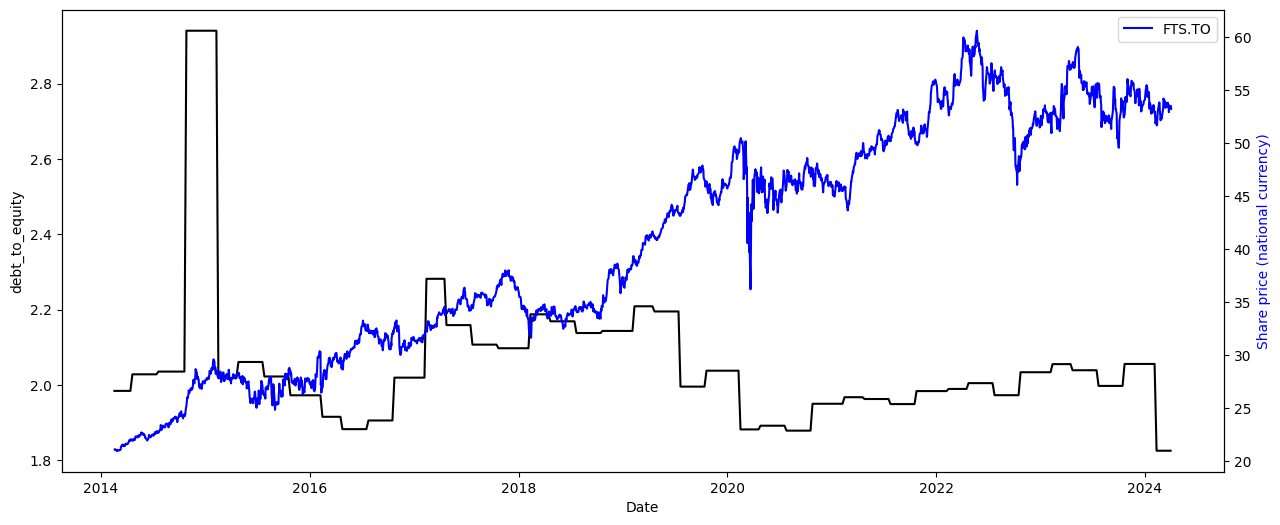

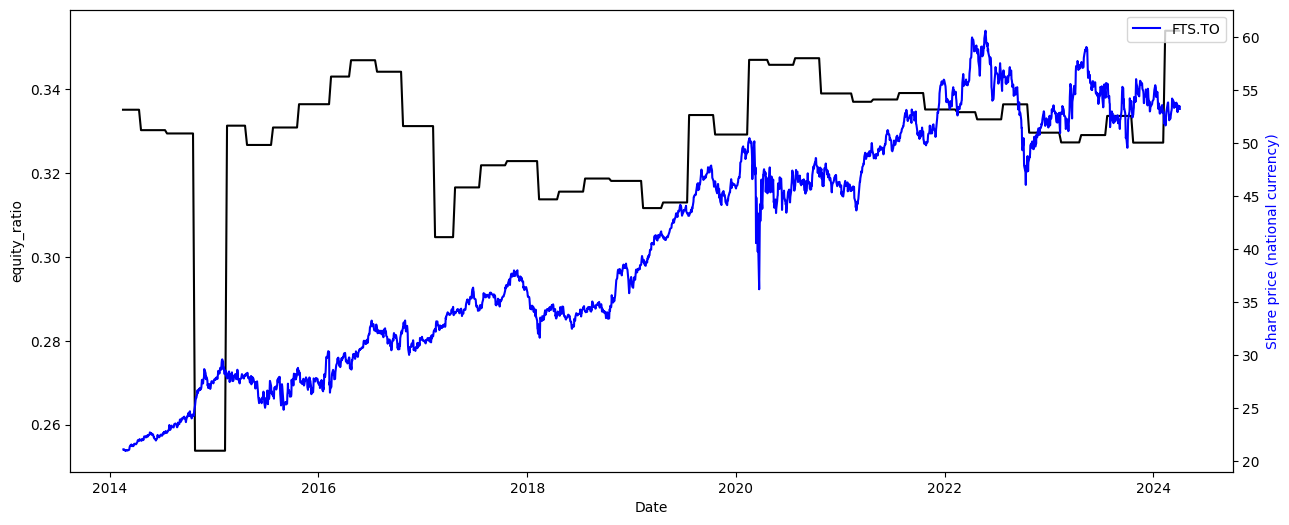

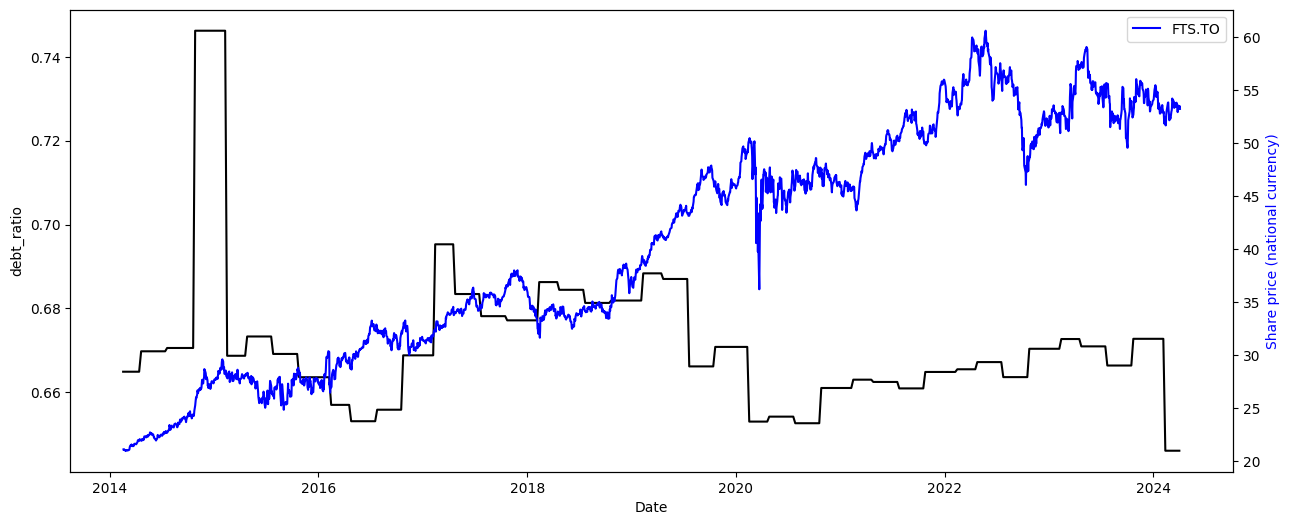

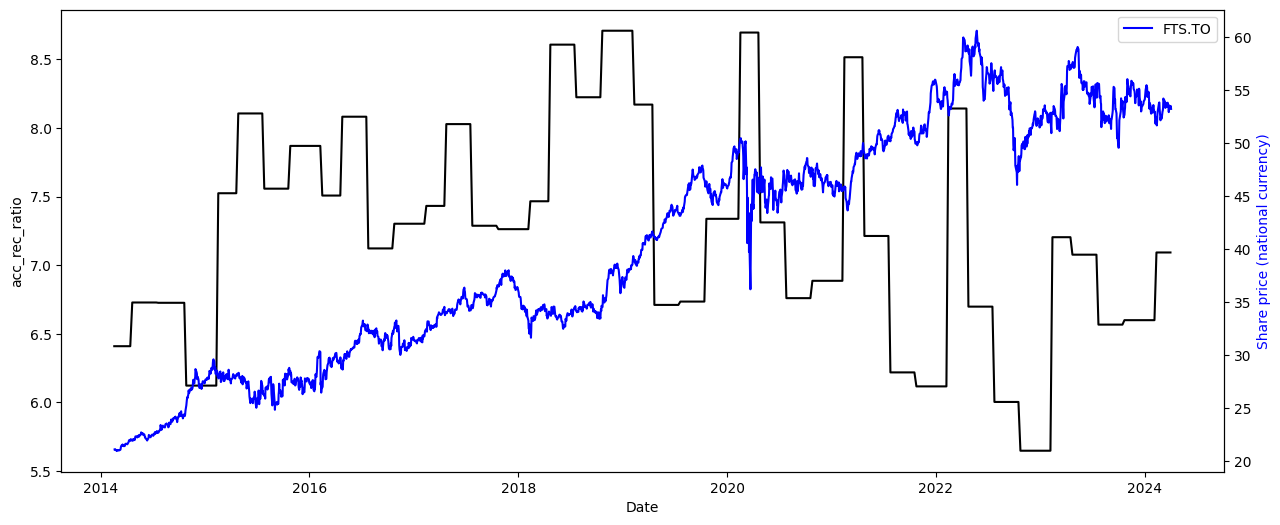

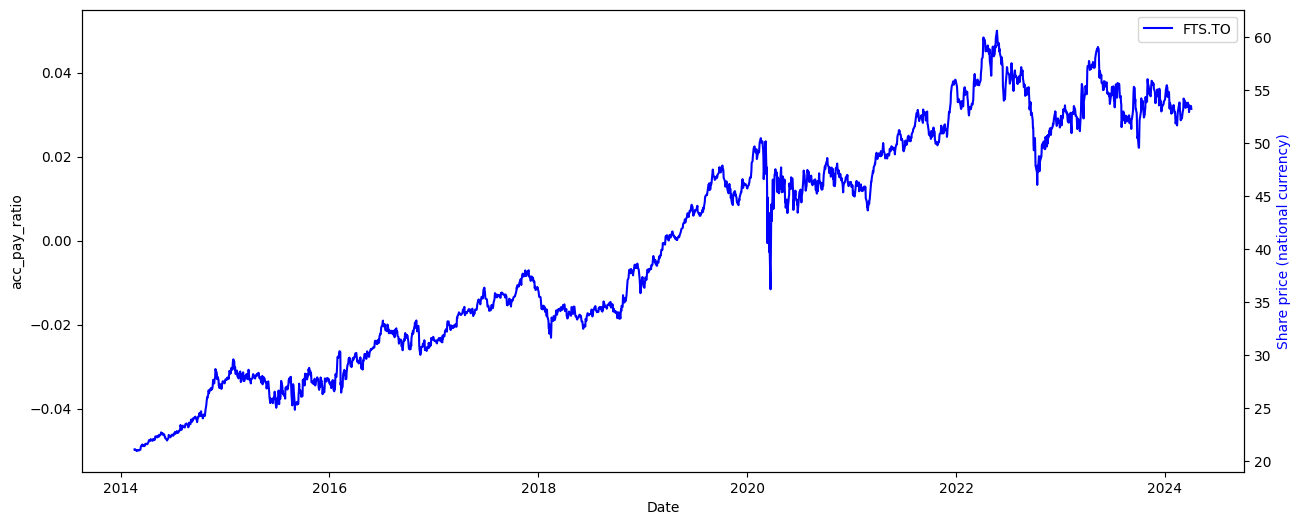

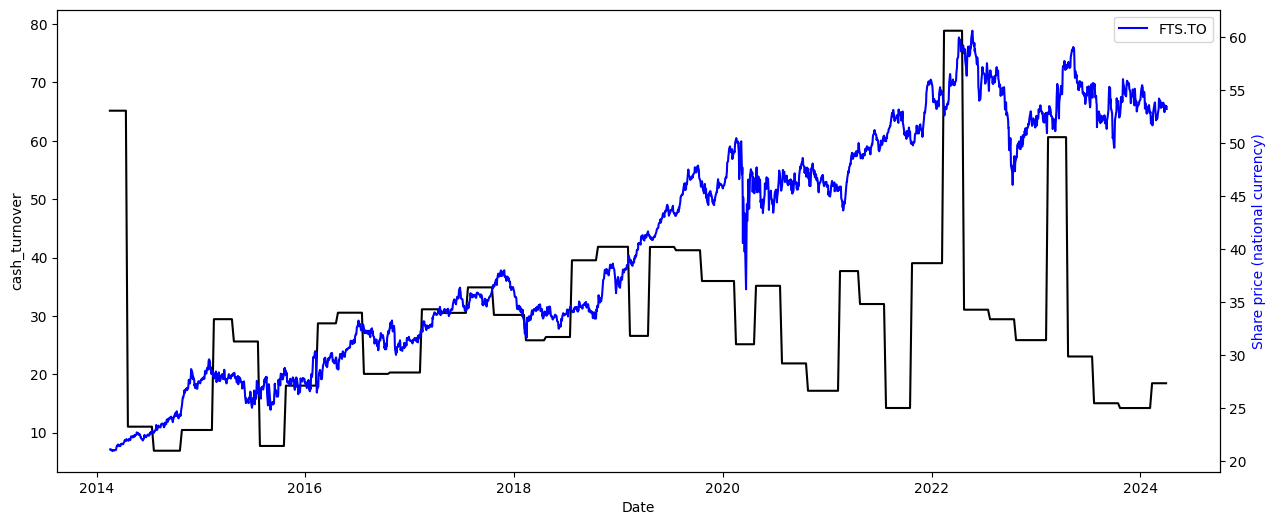

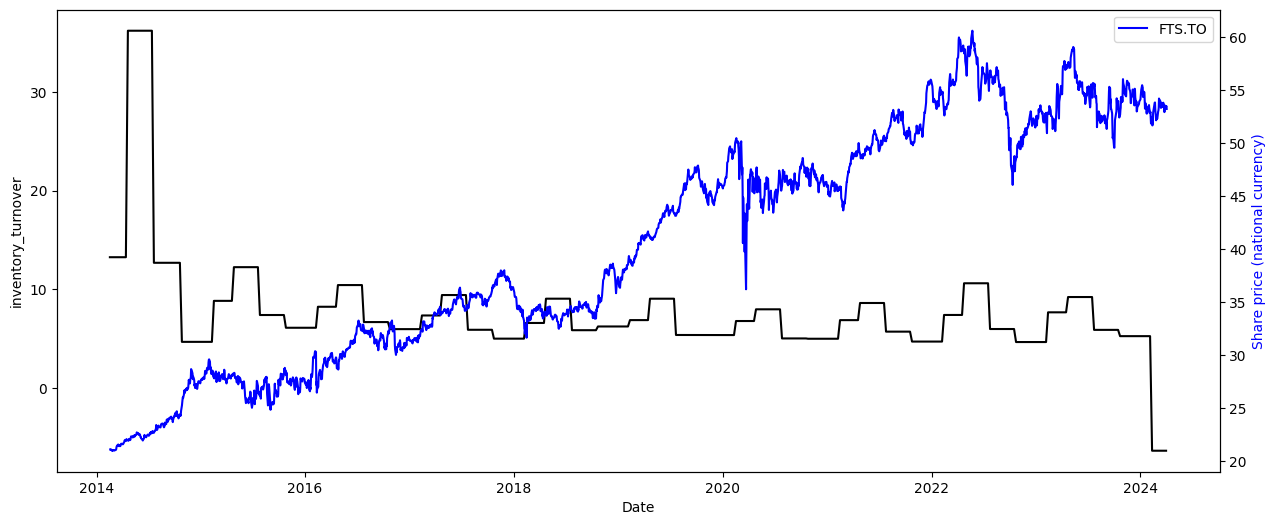

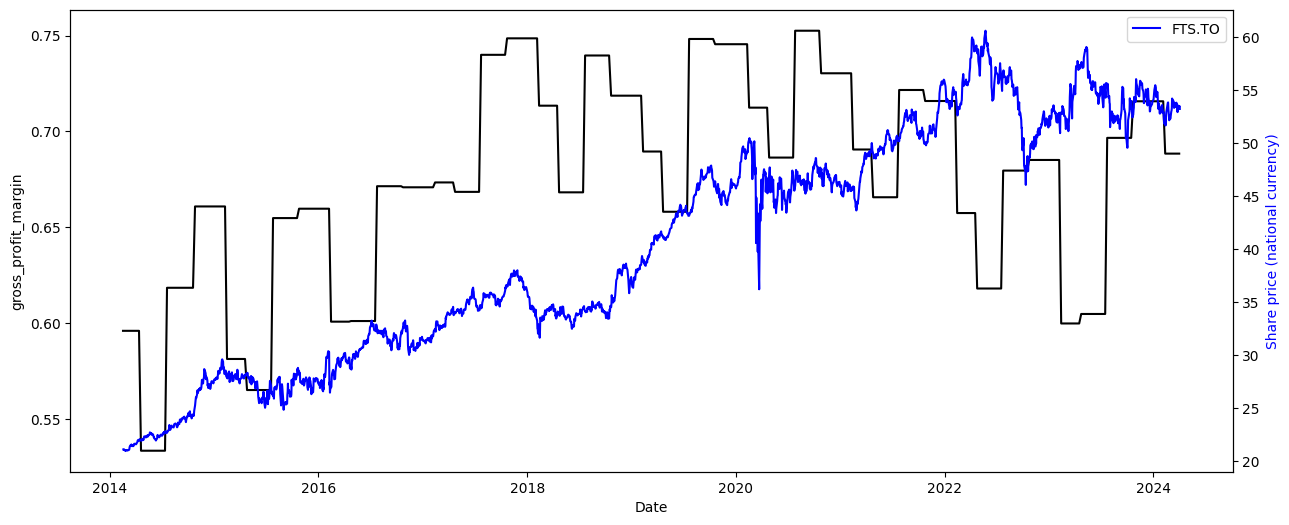

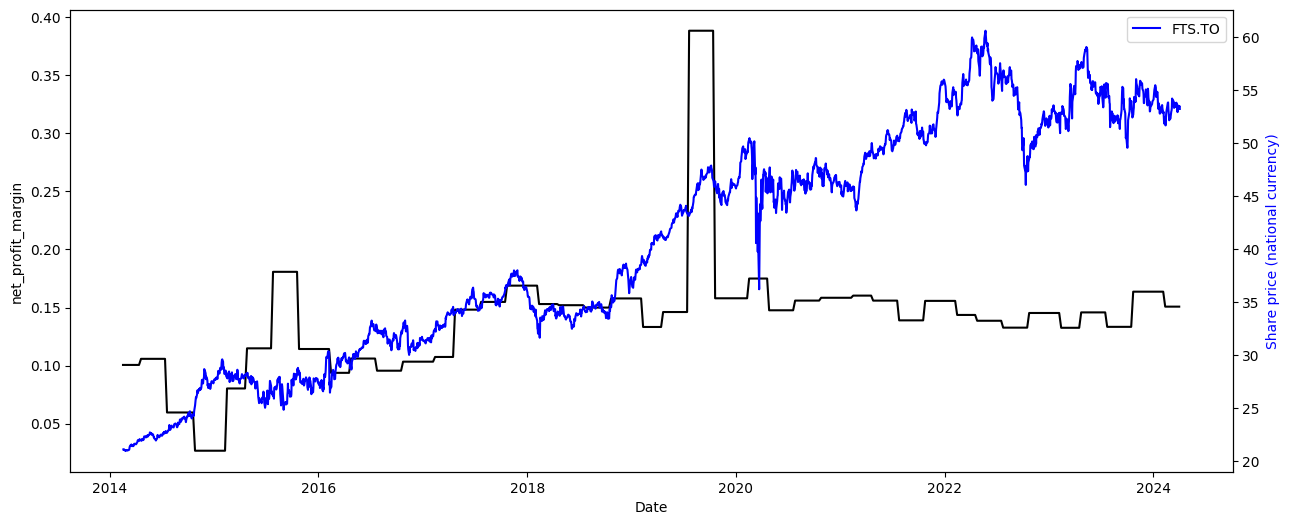

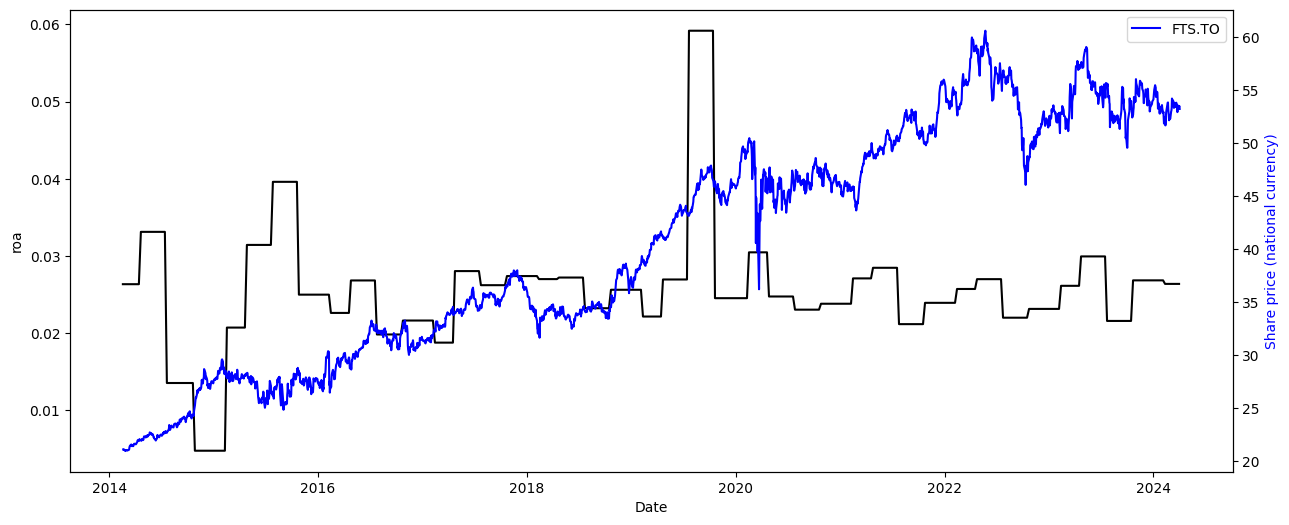

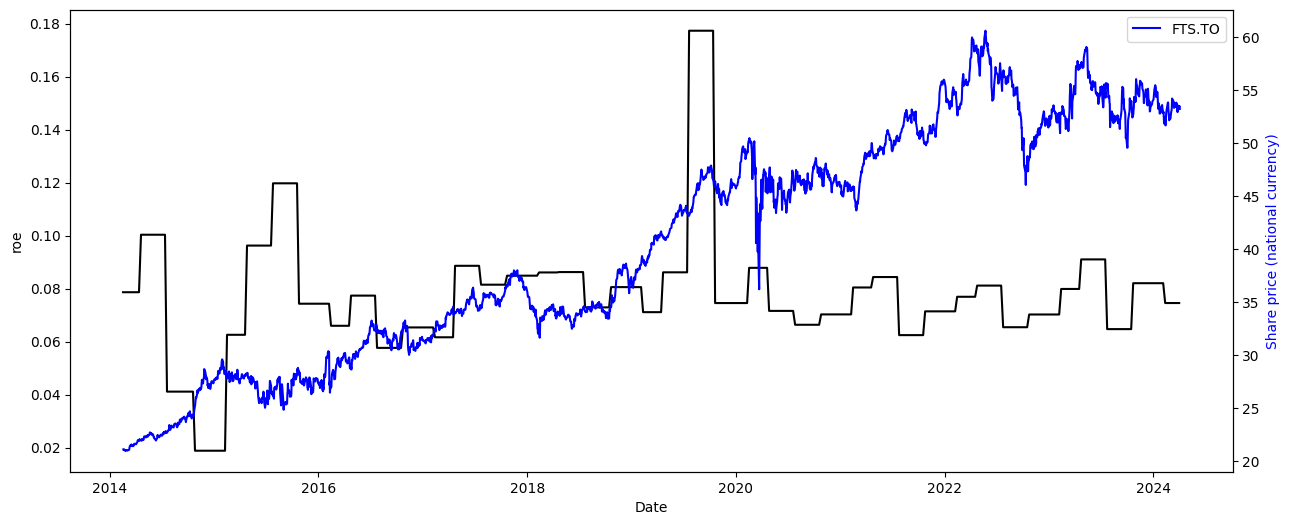

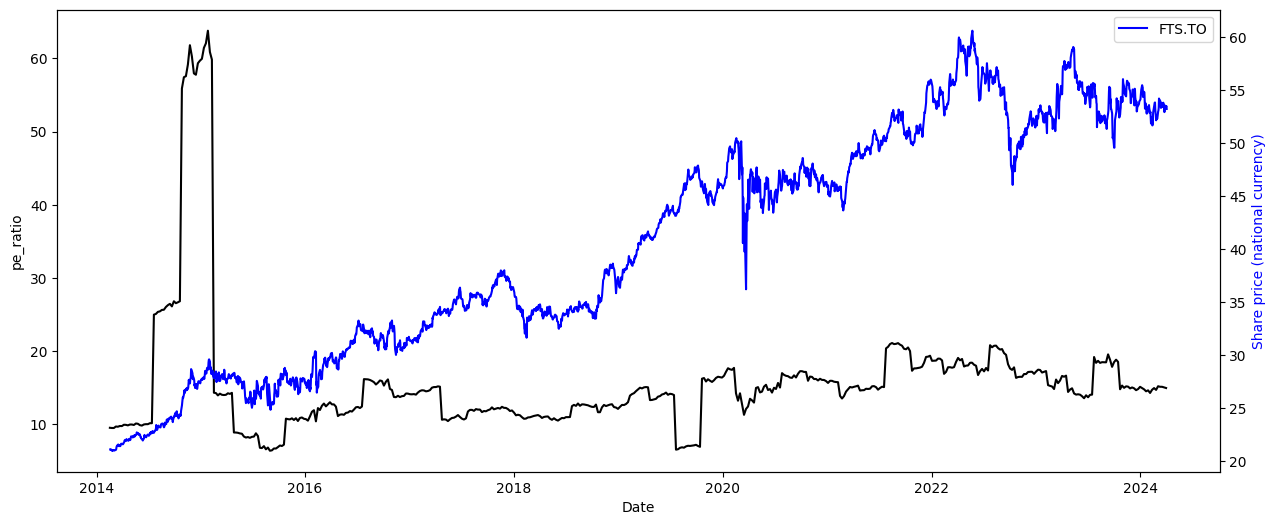

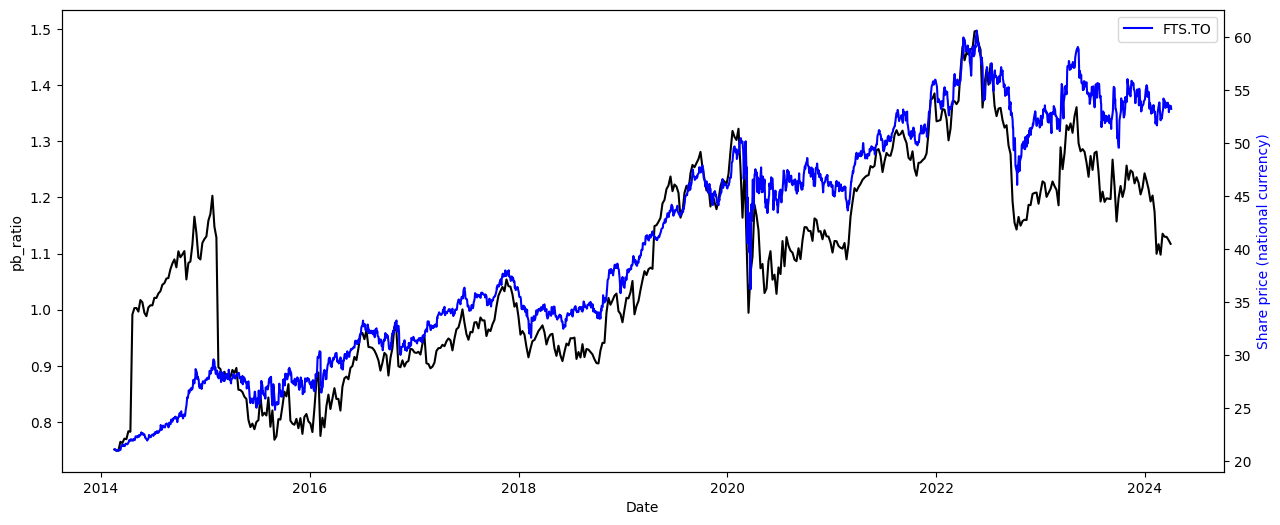

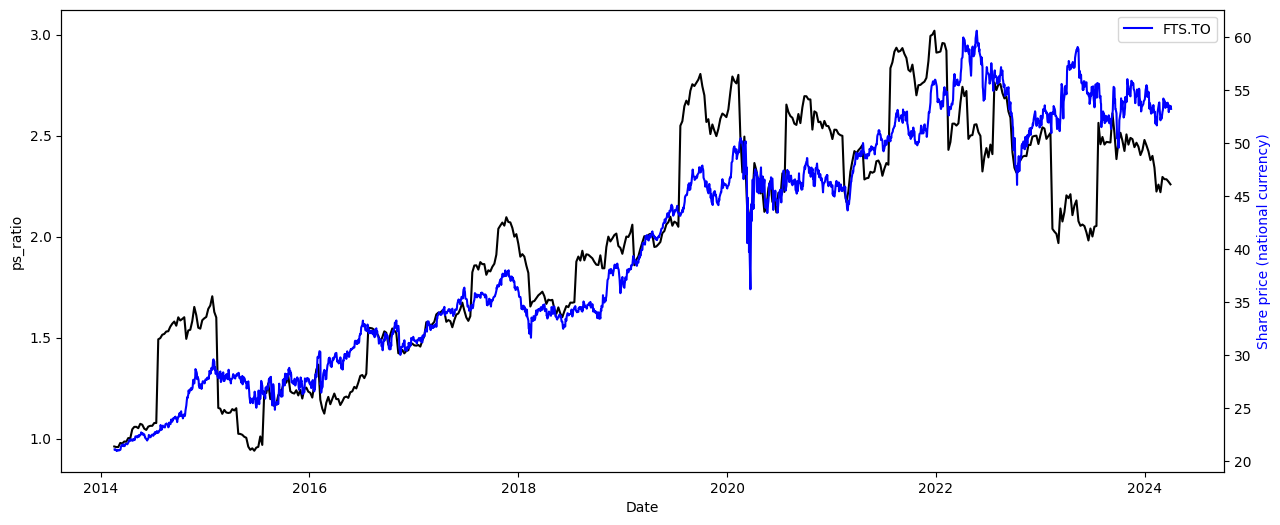

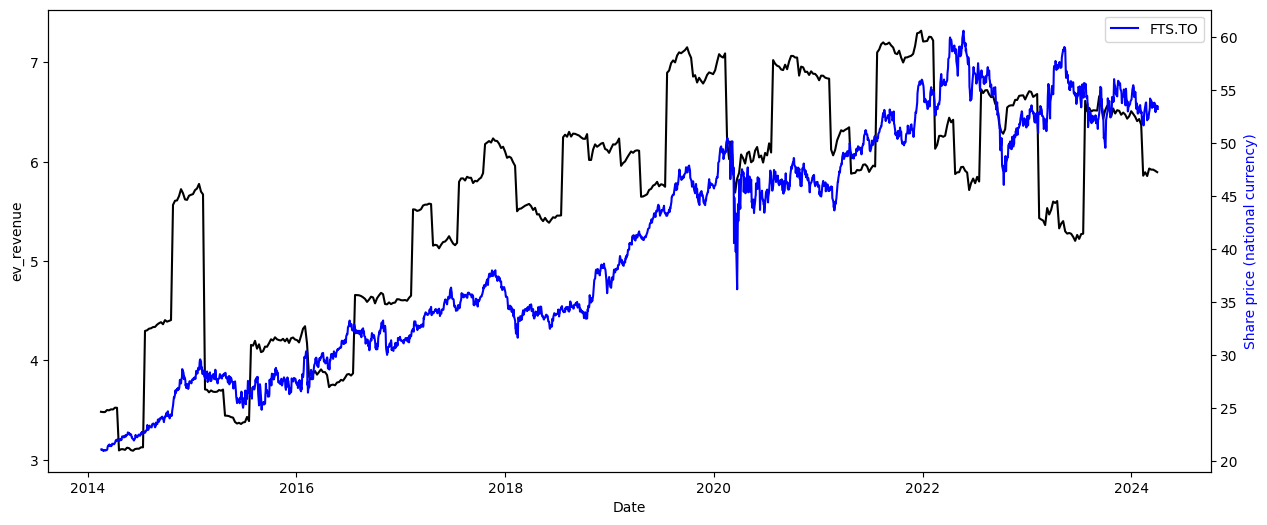

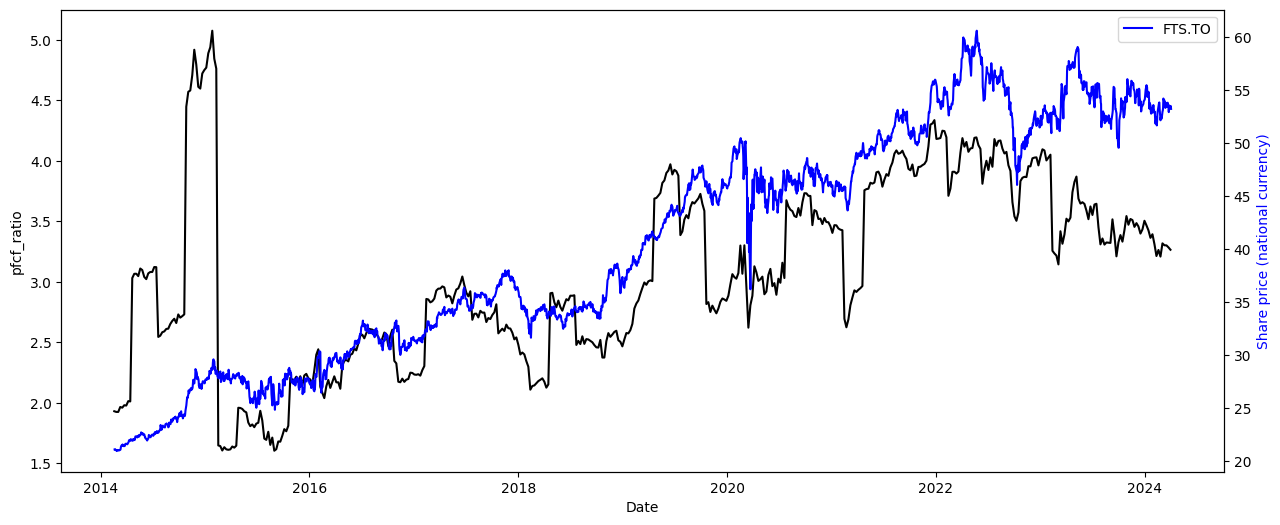

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

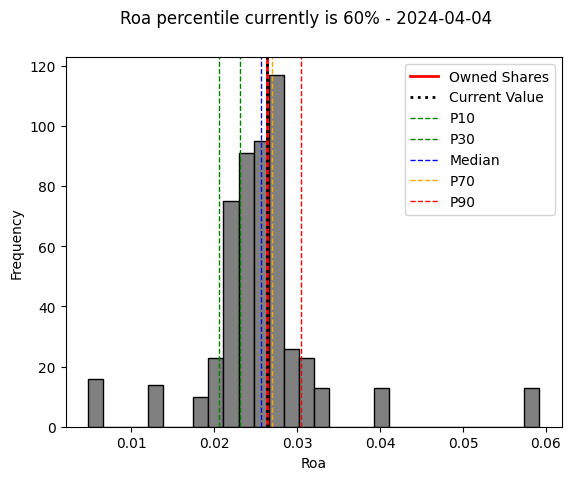

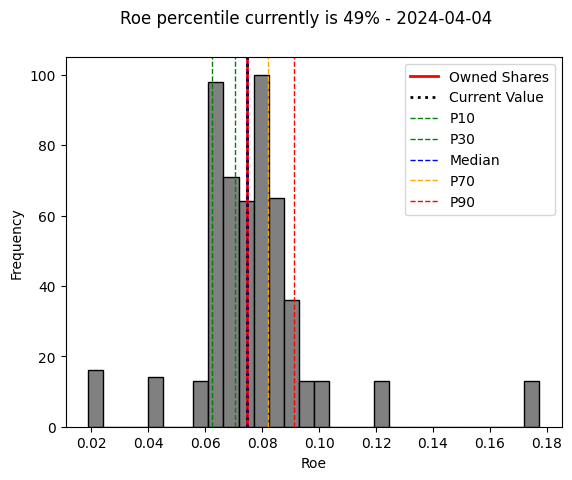

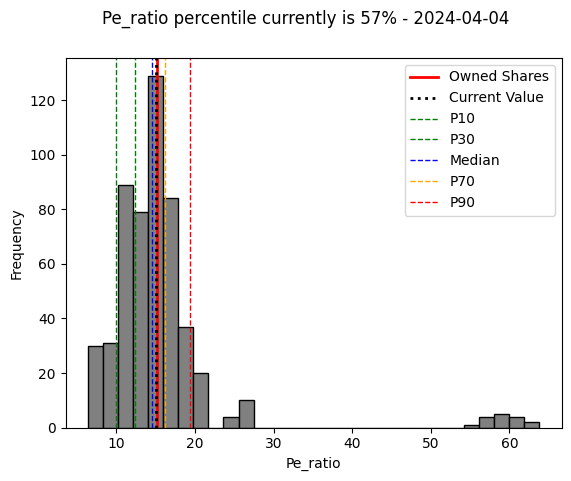

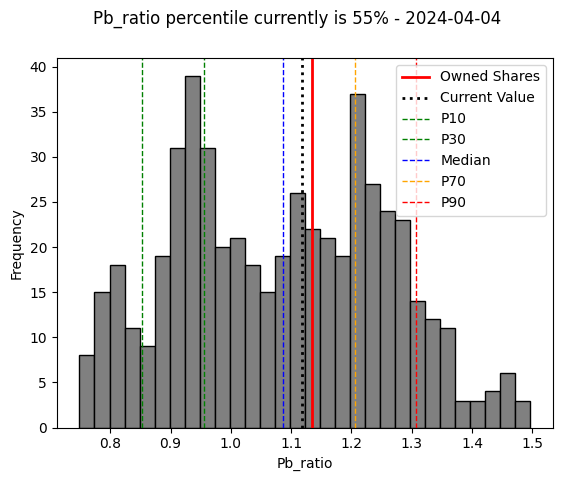

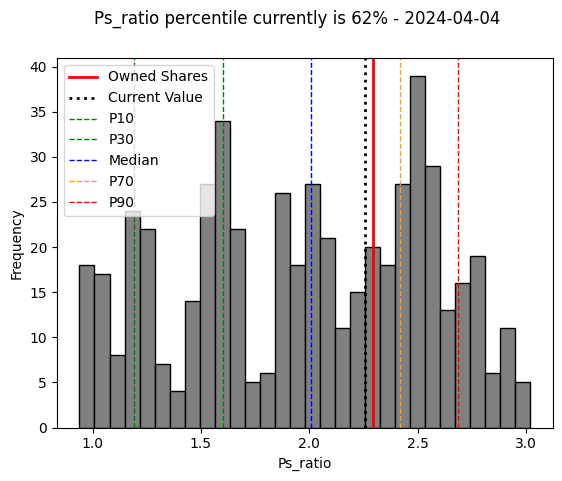

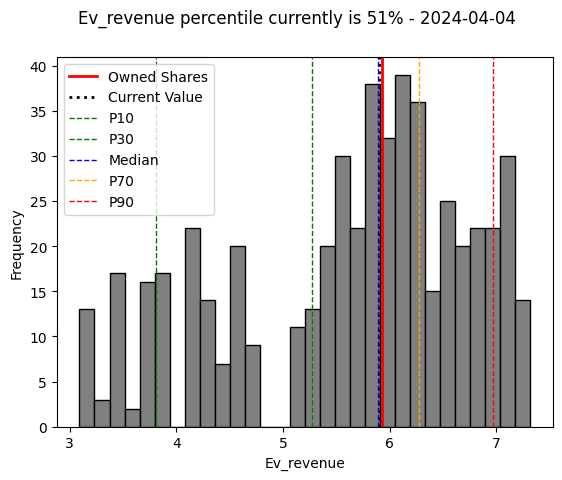

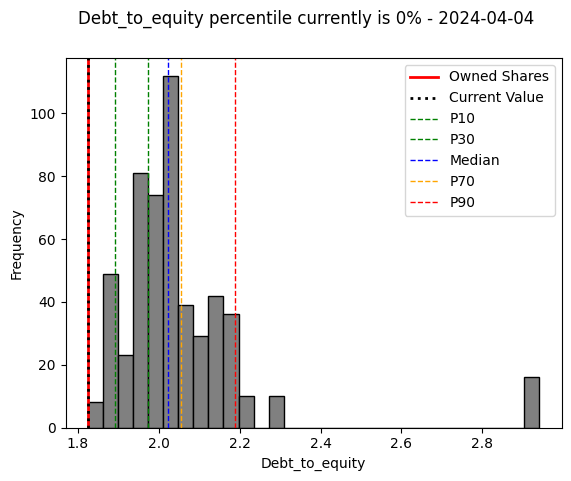

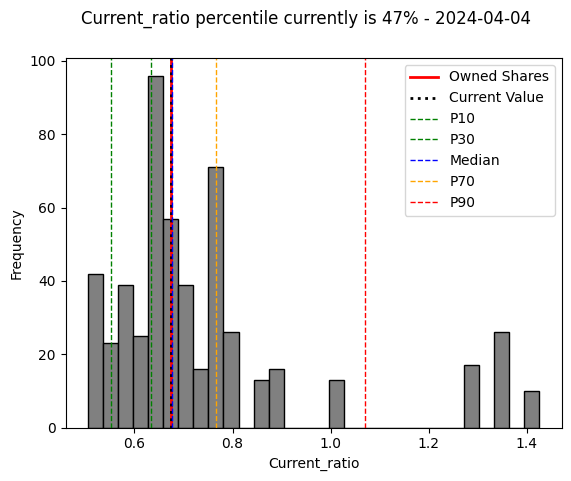

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.994288,-0.690368,0.018068,0.088190,0.008068,-0.419504,0.374267
roe,0.994288,1.000000,-0.680810,0.001398,0.064567,0.006832,-0.344905,0.364374
pe_ratio,-0.690368,-0.680810,1.000000,0.295979,0.116312,0.182374,0.721557,-0.046009
pb_ratio,0.018068,0.001398,0.295979,1.000000,0.857356,0.701698,-0.049059,0.158567
ps_ratio,0.088190,0.064567,0.116312,0.857356,1.000000,0.940029,-0.202307,0.180970
ev_revenue,0.008068,0.006832,0.182374,0.701698,0.940029,1.000000,0.006365,0.139765
debt_to_equity,-0.419504,-0.344905,0.721557,-0.049059,-0.202307,0.006365,1.000000,-0.047685
current_ratio,0.374267,0.364374,-0.046009,0.158567,0.180970,0.139765,-0.047685,1.000000


196 timestemos have been found!


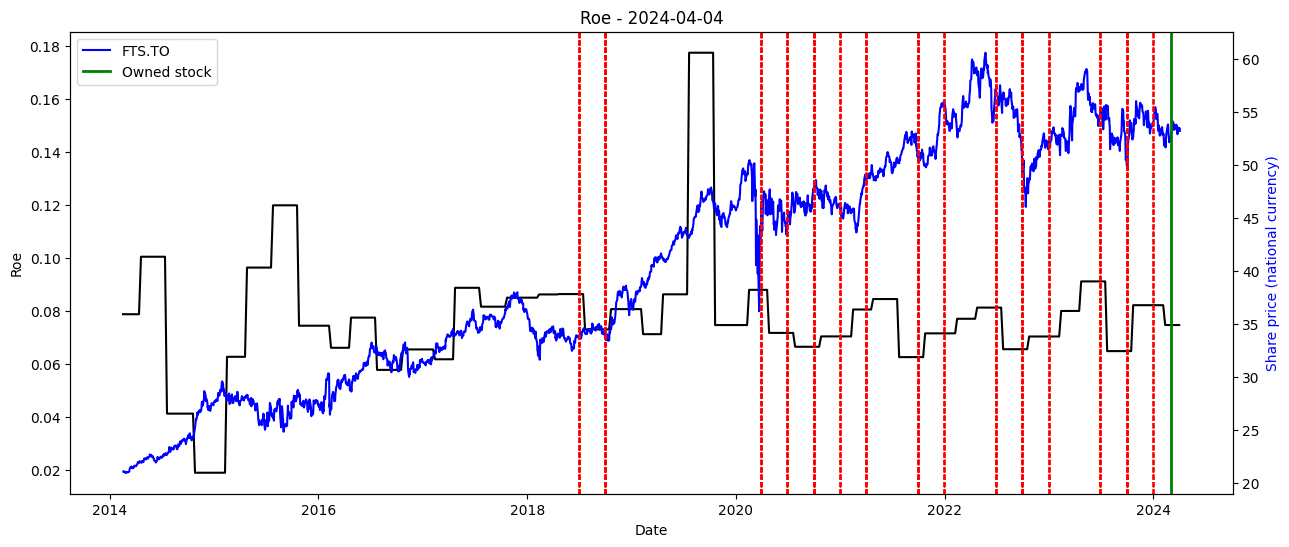

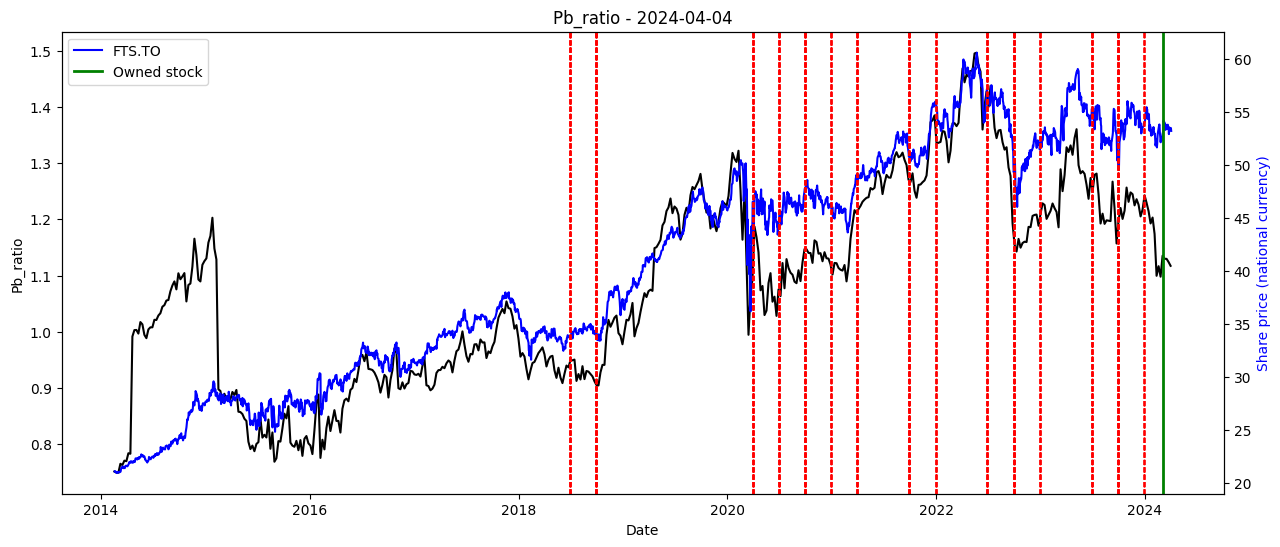

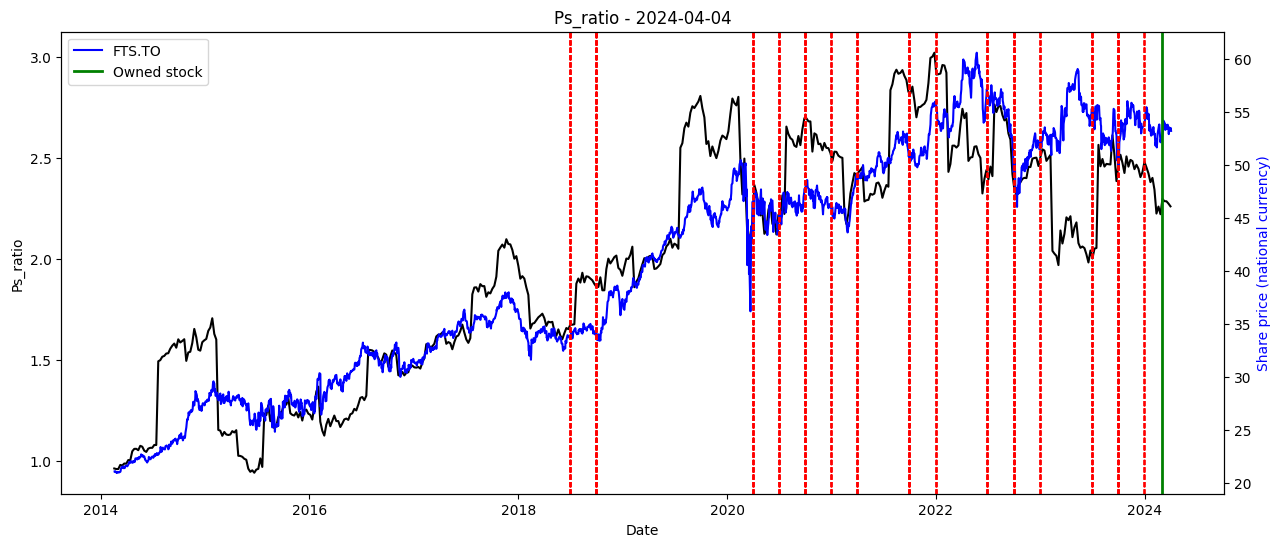

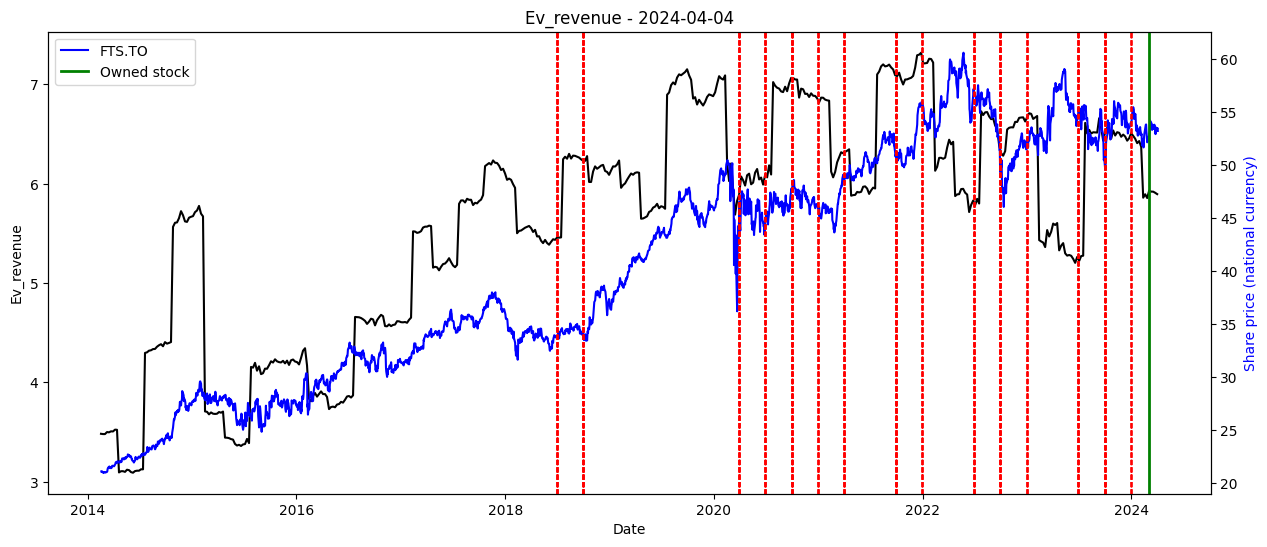

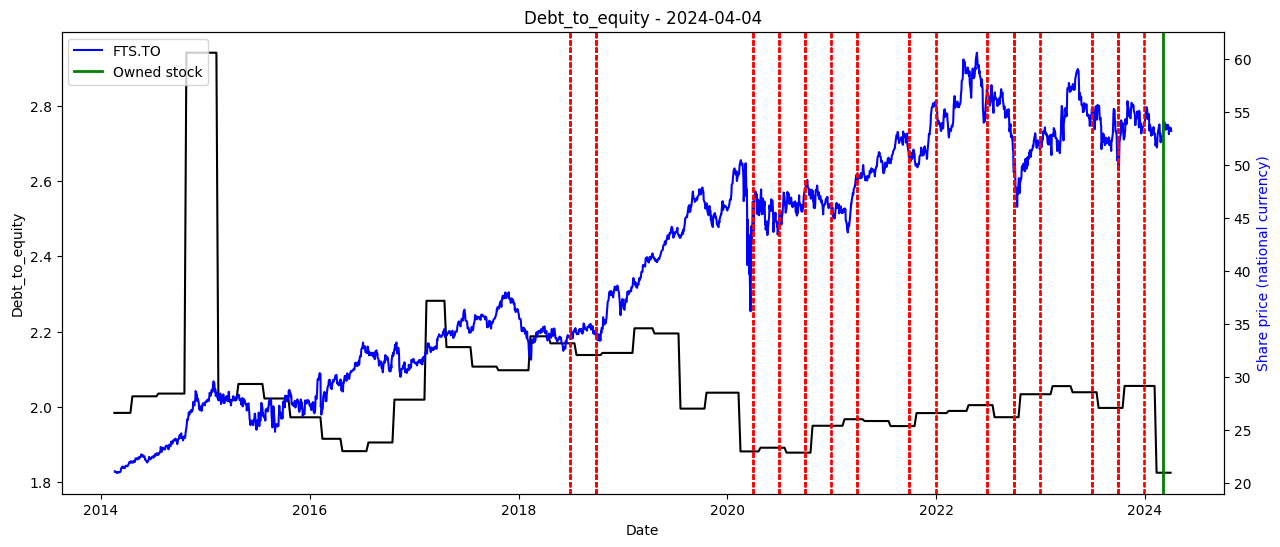

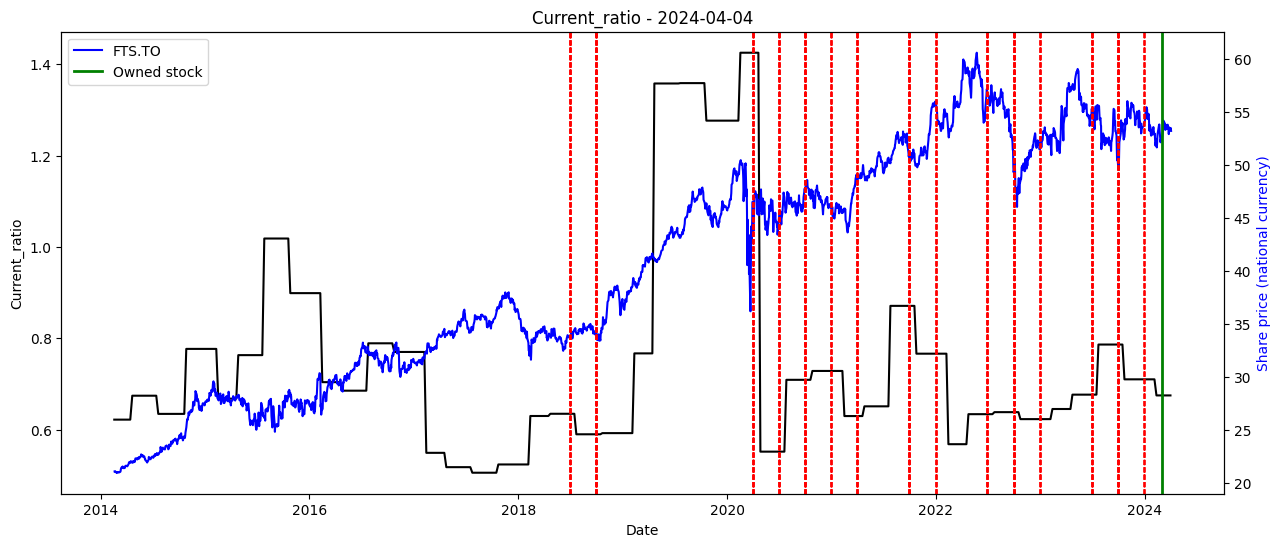

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )